In [1]:
import pickle
import time
from rich.progress import track
import numpy as np
import math
from scipy.special import binom, perm
from itertools import combinations, permutations, product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import random

from olympus.surfaces import CatCamel, CatMichalewicz, CatSlope, CatDejong # cat
from olympus.surfaces import Branin, Michalewicz, Levy, Dejong, Everest, Kilimanjaro, K2 # cont



In [58]:
#----------
# PLOTTING
#----------

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='RdBu') #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    
    
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
    domain = np.arange(21)
    Z = np.zeros((21, 21))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            Z[y_index, x_index] = loss_value
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = plt.get_cmap('RdBu'))
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
    
def plot_binary_scatter(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]
    
    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

    
def plot_binary_scatter_cat(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas_ = X[mask].values
    X_infs_ = X[~mask].values
    
    X_feas = []
    for x_ in X_feas_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_feas.append(x)
    
    X_infs = []
    for x_ in X_infs_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_infs.append(x)

    X_infs = np.array(X_infs)
    X_feas = np.array(X_feas)
    
    ax.scatter(X_feas[:,0], X_feas[:,1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs[:,0], X_infs[:,1], marker='X', s=100, color='white', edgecolor='k', zorder=10)

In [39]:
#------------------
# HELPER FUNCTIONS
#------------------
def stirling_sum(Ns):
    """ ...
    """
    stirling = lambda n,k: int(1./math.factorial(k) * np.sum([(-1.)**i * binom(k,i)*(k-i)**n for i in range(k)]))
    return np.sum([stirling(Ns, k) for k in range(Ns+1)])

def partition(S):
    """ ...
    """
    if len(S) == 1:
        yield [S]
        return 

    first = S[0]
    for smaller in partition(S[1:]):
        for n, subset in enumerate(smaller):
            yield smaller[:n]+[[first] + subset]+smaller[n+1:]
        yield [[first]]+smaller 
    
def gen_partitions(S):
    """
    generate all possible partitions of Ns-element set S
    
    Args: 
        S (list): list of non-functional parameters S
    """
    return [p for _, p in enumerate(partition(S),1)]


def gen_permutations(X_funcs, Ng):
    """ generate all possible functional parameter permutations
    given number of non-functional parameter subsets Ng
    
    Args: 
        X_funcs (np.ndarray): numpy array with all functional 
            possile functional parameters
        Ng (int): number of non-functional parameter subsets
        
    Returns
        (np.ndarray): array of parameter permutations of
            shape (# perms, Ng, # params)
    """
    
    return np.array(list(permutations(X_funcs, Ng)))

def measure_objective(xgs, G, surf_map, is_categorical):
    """ ... 
    """
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        for si in Sg:
            f_x += measure_single_obj(xgs[g_ix], si, surf_map, is_categorical)
    return f_x


def measure_single_obj(X_func, si, surf_map, is_categorical):
    if is_categorical:
        X_func = list([str(elem) for elem in X_func])
    return surf_map[si].run(X_func)[0][0]


def estimate_optima(S, surf_map, num_samples=int(1e4), is_categorical=False):
    """ Estimates optimum for each of the possible Ngs
    """
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: [] for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
    print(fxs)
    
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    # histogram of Ngs
    for G in Gs:
        num_Ngs[len(G)] += 1
    
    for G_ix, G in track(enumerate(Gs), total=len(Gs), description='Evaluating candidates'):
        Ng = len(G)
        # so we eval same num total points on each Ng
        num_samples_eff = int(num_samples/num_Ngs[Ng]) 
        print(f'G : {G}\t num_samples_eff : {num_samples_eff}\t num_samples : {num_samples}')
         
        if is_categorical:
            # categorical surfaces
            opts = [f'x{i}' for i in range(21)]
            X_funcs = np.random.choice(opts, replace=True, size=(num_samples_eff, Ng, 2))            
        else:
            # continuous surface
            # generate samples
            X_funcs =  np.random.uniform(size=(num_samples_eff, Ng, 2)) # 2d functions only
        
        for X_func in X_funcs:
            f_x = measure_objective(X_func, G, surf_map, is_categorical=is_categorical)
            fxs[Ng].append({'G': G, 'X_func': X_func,'f_x': f_x,})

    
            
    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    
    # get the best (min) values
    best_vals = {}
    for Ng in poss_Ngs:
        
        fxs_Ng = fxs[Ng]
        fx_vals_Ng = [d['f_x'] for d in fxs_Ng]
        best_idx = np.argmin(fx_vals_Ng)
        best_dict = fxs_Ng[best_idx]
        best_vals[Ng] = best_dict
        
    
    
    return best_vals, fxs

#---------------------------
# BUCHWALD DATASET SPECIFIC
#---------------------------

def buchwald_lookup(params, target, lookup):
    """ lookup the yield for a given functional/non-functional
    parameter setting
    """
    base = params[0]
    ligand = params[1]
    additive = params[2]
    sub_df = lookup[
        (lookup['base_ix']==base) &
        (lookup['ligand_ix']==ligand) &
        (lookup['additive_ix']==additive) &
        (lookup['aryl_halide_ix']==target)
    ]
    if sub_df.shape[0] == 1:
        yield_ = sub_df.loc[:, 'yield'].to_numpy()[0]
    elif sub_df.shape[0] < 1:
        yield_ = 0.0
    
    return yield_

def measure_objective_buchwald(xgs, G, lookup):
    """
    Args:
        x_gs (np.ndarray): array of proposed general parameters (Ng x 1)
        G (dict): keys are indices of non-functional subsets Sg, values are lists
            of non-functional parameter names assigned to that subset
    """
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        for si in Sg:
            f_x += buchwald_lookup(xgs[g_ix], si, lookup)
        
    return f_x



def estimate_optima_buchwald(S, lookup, num_samples=int(1e4)):
    """ Estimates optimum for each of the possible Ngs
    """
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: [] for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
    #print(fxs)
    
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    # histogram of Ngs
    for G in Gs:
        num_Ngs[len(G)] += 1
    
    #print(num_Ngs)
    
    for G_ix, G in track(enumerate(Gs), total=len(Gs), description='Evaluating candidates'):
        Ng = len(G)
        # so we eval same num total points on each Ng
        num_samples_eff = int(num_samples/num_Ngs[Ng]) 
        #print(f'G : {G}\t num_samples_eff : {num_samples_eff}\t num_samples : {num_samples}')
         
        base_opts = np.arange(3)
        ligand_opts = np.arange(4)
        additive_opts = np.arange(23)
        base_select_opts = np.random.choice(base_opts, replace=True, size=(num_samples_eff*Ng,))
        ligand_select_opts = np.random.choice(ligand_opts, replace=True, size=(num_samples_eff*Ng,))
        additive_select_opts = np.random.choice(additive_opts, replace=True, size=(num_samples_eff*Ng,))
        X_funcs = np.stack((base_select_opts, ligand_select_opts, additive_select_opts), axis=0)
        X_funcs = X_funcs.reshape((num_samples_eff, Ng, 3))
        
        for X_func in X_funcs:
            f_x = measure_objective_buchwald(X_func, G, lookup)
            fxs[Ng].append({'G': G, 'X_func': X_func,'f_x': f_x,})

    
            
    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    
    # get the best (min) values
    best_vals = {}
    for Ng in poss_Ngs:
        
        fxs_Ng = fxs[Ng]
        fx_vals_Ng = [d['f_x'] for d in fxs_Ng]
        best_idx = np.argmax(fx_vals_Ng) # maximizing yield in this case
        best_dict = fxs_Ng[best_idx]
        best_vals[Ng] = best_dict
        
    
    
    return best_vals, fxs


In [64]:
#------------
# CONTINUOUS
#------------

surf_map = {
    0: Branin(),
    1: Dejong(),
    2: Michalewicz(),
    3: Levy(),
#     #4: Everest(), 
#     #5: Kilimanjaro(),
#     #6: K2()
}


#-------------
# CATEGORICAL
#-------------

# surf_map = {
#     0: CatCamel(param_dim=2, num_opts=21),
#     1: CatDejong(param_dim=2, num_opts=21),
#     2: CatMichalewicz(param_dim=2, num_opts=21),
#     #3: CatSlope(param_dim=2, num_opts=21),
# }

S = [i for i in range(len(surf_map))]
poss_Ngs = np.arange(len(S))+1

In [65]:
best_vals, fxs = estimate_optima(S, surf_map, num_samples=int(1e5), is_categorical=False)

{1: [], 2: [], 3: [], 4: []}
total non-functional partitions :  15


Output()

G : [[0, 1, 2, 3]]       num_samples_eff : 100000        num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

G : [[0], [1, 2, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

G : [[0, 1], [2, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   7% -:--:--

G : [[1], [0, 2, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  13% 0:00:07

G : [[0], [1], [2, 3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  20% 0:00:07

G : [[0, 1, 2], [3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  27% 0:00:07

G : [[1, 2], [0, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━  33% 0:00:06

G : [[0], [1, 2], [3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━  40% 0:00:06

G : [[0, 2], [1, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━  47% 0:00:05

G : [[2], [0, 1, 3]]     num_samples_eff : 14285         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━  53% 0:00:05

G : [[0], [2], [1, 3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━  60% 0:00:04

G : [[0, 1], [2], [3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 0:00:03

G : [[1], [0, 2], [3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━  73% 0:00:03

G : [[1], [2], [0, 3]]   num_samples_eff : 16666         num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━  80% 0:00:02

G : [[0], [1], [2], [3]]         num_samples_eff : 100000        num_samples : 100000
Evaluating candidates ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━  87% 0:00:02

[INFO] Done in 15.62 s


In [66]:
# make a plot of the pareto front with all values
# all_fxs = []
# for poss_Ng in poss_Ngs:
#     all_fxs.extend(fxs[poss_Ng])

# arr = np.array([[len(d['G']), d['f_x']] for d in all_fxs])

# fig, ax = plt.subplots()

# ax.scatter(arr[:, 0], arr[:, 1], alpha=0.2)
# ax.set_ylim(5, 100)
# ax.set_yscale('log')

# ax.set_xlabel('# functional parameter sets',fontsize=14)
# ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

Text(0, 0.5, 'objective function, $f(\\mathbf{x})$')

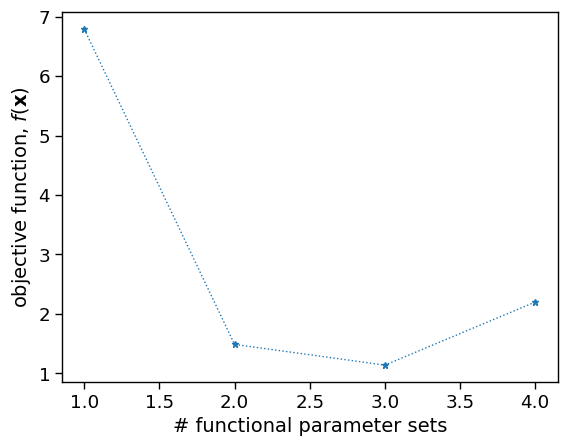

In [67]:
# make a plot of the pareto front with only best values
all_fxs = []
for poss_Ng in poss_Ngs:
    all_fxs.append(best_vals[poss_Ng])

arr = np.array([[len(d['G']), d['f_x']] for d in all_fxs])

fig, ax = plt.subplots()

ax.plot(arr[:, 0], arr[:, 1], ls=':', lw=1, marker='*', markersize=5,)
#ax.set_yscale('log')

ax.set_xlabel('# functional parameter sets',fontsize=14)
ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

In [68]:
best_vals

{1: {'G': [[0, 1, 2, 3]],
  'X_func': array([[0.52992194, 0.2453861 ]]),
  'f_x': 6.79164483902394},
 2: {'G': [[0], [1, 2, 3]],
  'X_func': array([[0.14101319, 0.78516641],
         [0.56239096, 0.47487582]]),
  'f_x': 1.487196121421653},
 3: {'G': [[0], [2], [1, 3]],
  'X_func': array([[0.95988913, 0.16114074],
         [0.5909505 , 0.84062775],
         [0.54647862, 0.50798998]]),
  'f_x': 1.1382833916573003},
 4: {'G': [[0], [1], [2], [3]],
  'X_func': array([[0.5580868 , 0.1605251 ],
         [0.54629159, 0.71376848],
         [0.71272957, 0.28361626],
         [0.53771131, 0.52135451]]),
  'f_x': 2.1991364908738458}}

In [9]:
# get the minimum of the each cat surface 
mins_ = []
for ix, surf in surf_map.items():
    print(surf.minima)
    mins_.append(surf.minima[0]['value'])
abs_min_ = np.sum(mins_) # theoretical best value

print('theoretical best : ', abs_min_)

[{'params': ['x7', 'x11'], 'value': 12.177205282080257}]
[{'params': ['x10', 'x10'], 'value': 0.0}]
[{'params': ['x14', 'x10'], 'value': -1.8010702893119994}]
theoretical best :  10.376134992768257


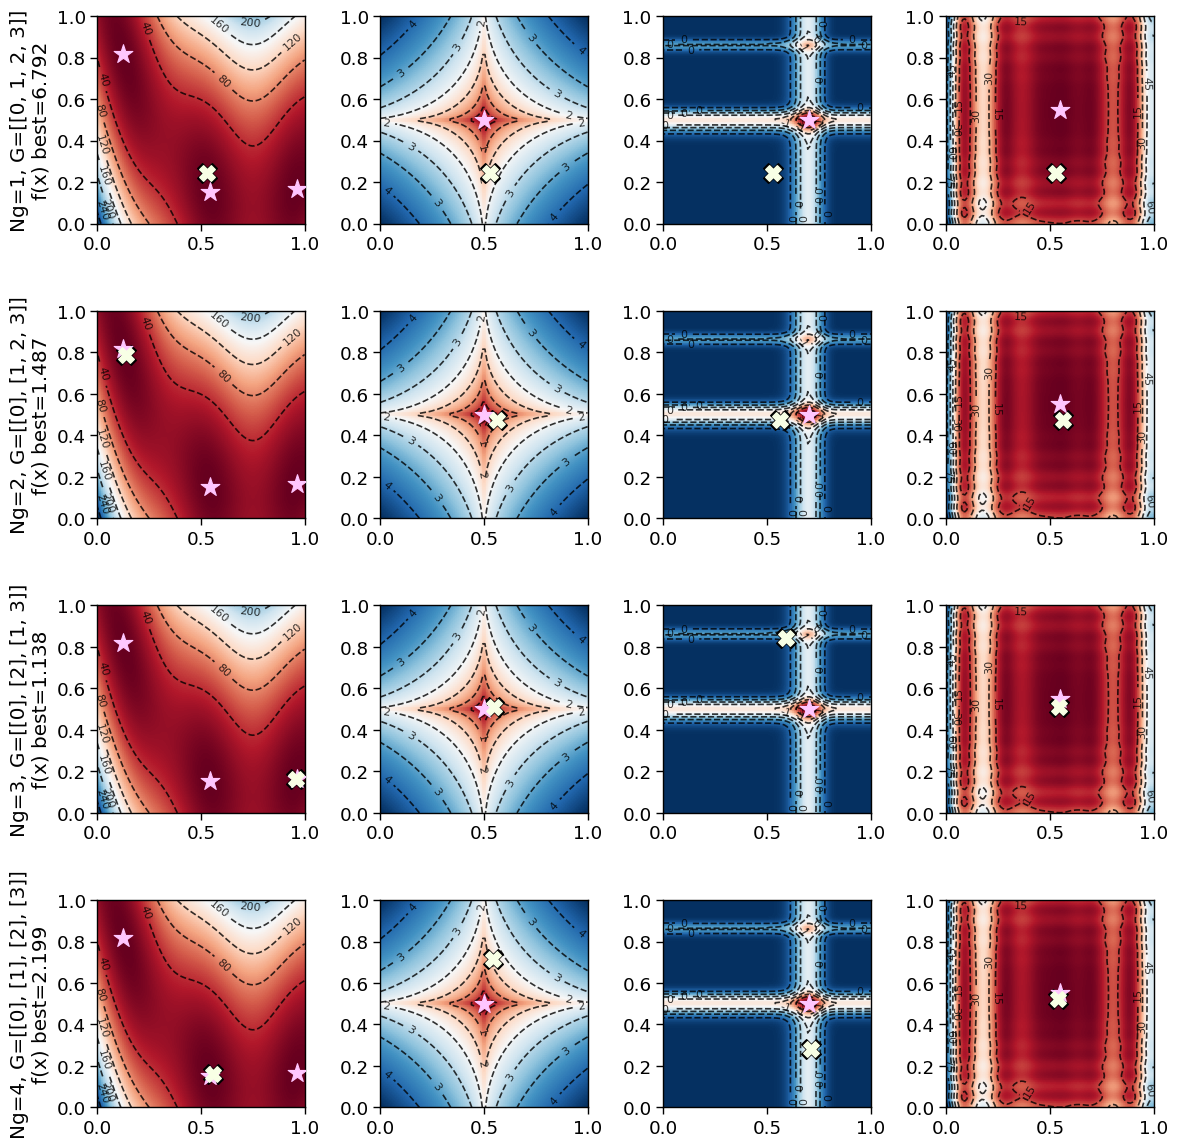

In [76]:
# plot surfaces
fig, axes = plt.subplots(4,4,figsize=(12, 12))



for Ng in poss_Ngs:

    surf1 = Branin()
    plot_surface(surf1, ax=axes[Ng-1,0], N=100)
    surf2 = Dejong()
    plot_surface(surf2, ax=axes[Ng-1,1], N=100)
    surf3 = Michalewicz()
    plot_surface(surf3, ax=axes[Ng-1,2], N=100)
    surf4 = Levy()
    plot_surface(surf4, ax=axes[Ng-1,3], N=100)


for Ng in poss_Ngs:
    f_x_best = best_vals[Ng]['f_x']
    G_best = best_vals[Ng]['G']
    X_func_best = best_vals[Ng]['X_func']
    for X, S in zip(X_func_best, G_best):
        for si in S:
            axes[Ng-1, si].scatter(
                X[0], X[1], 
                marker='X', s=125, 
                color='#f8ffe5', linewidth=1, 
                zorder=20,
            )
            axes[Ng-1,si].scatter(
                X[0], X[1], 
                marker='X', s=200, 
                color='k', linewidth=1, 
                zorder=19,
            )
            # add ylabel
            axes[Ng-1,0].set_ylabel(f'Ng={Ng}, G={G_best}\nf(x) best={round(f_x_best,3)}')

plt.tight_layout()

## Buchwald-Hartwig cross-coupling dataset

functional parameters: `base_ix`, `ligand_ix`, `additive_ix`

non-functional/general parameters: `aryl_halide_ix`

objective: `yield` (maximize, percentage)

In [27]:
df = pickle.load(open('buchwald/main_df.pkl', 'rb'))
print(df.shape)
print('num_base : ', len(df['base_ix'].unique()))
print('num_ligand : ', len(df['ligand_ix'].unique()))
print('num_additive : ', len(df['additive_ix'].unique()))
print('num product : ', np.prod([3,4,23]))
df.head()

(4132, 129)
num_base :  3
num_ligand :  4
num_additive :  23
num product :  276


,base_ix,base_name,ligand_ix,ligand_name,aryl_halide_ix,aryl_halide_name,additive_ix,additive_name,yield,base_*N1_electrostatic_charge,...,additive_E_LUMO,additive_V1_frequency,additive_V1_intensity,additive_dipole_moment,additive_electronegativity,additive_hardness,additive_molecular_volume,additive_molecular_weight,additive_ovality,additive_surface_area
0,0,P2Et,0,XPhos,0,1-chloro-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,10.657812,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
1,0,P2Et,0,XPhos,1,1-bromo-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,14.747896,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
2,0,P2Et,0,XPhos,2,1-iodo-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,18.278686,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
3,0,P2Et,0,XPhos,3,1-chloro-4-methoxybenzene,0,5-phenylisoxazole,2.475058,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
4,0,P2Et,0,XPhos,4,1-bromo-4-methoxybenzene,0,5-phenylisoxazole,6.119058,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87


In [45]:
S = list(np.arange(7))
poss_Ngs = np.arange(len(S))+1

best_vals, fxs = estimate_optima_buchwald(S, df, num_samples=int(1e3))



total non-functional partitions :  877


Output()

[INFO] Done in 13.36 s


Text(0, 0.5, 'objective function, $f(\\mathbf{x})$')

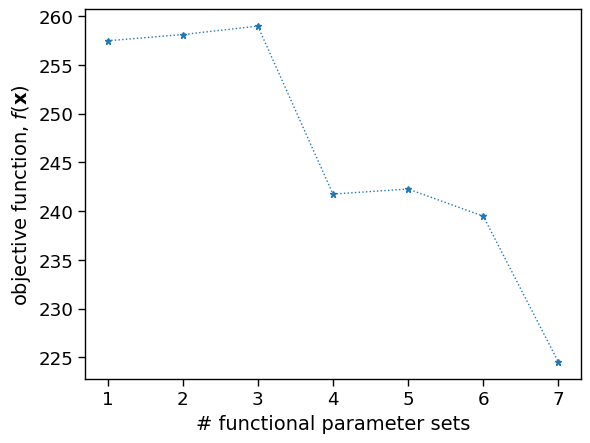

In [46]:
# make a plot of the pareto front with only best values
all_fxs = []
for poss_Ng in poss_Ngs:
    all_fxs.append(best_vals[poss_Ng])

arr = np.array([[len(d['G']), d['f_x']] for d in all_fxs])

fig, ax = plt.subplots()

ax.plot(arr[:, 0], arr[:, 1], ls=':', lw=1, marker='*', markersize=5,)
#ax.set_yscale('log')

ax.set_xlabel('# functional parameter sets',fontsize=14)
ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

In [54]:
# get the theoretical max obejctive value for the buchwald dataset
# make cartesian product space of options
base_opts = np.arange(3)
ligand_opts = np.arange(4)
additive_opts = np.arange(23)

cart_product = np.array(list(product(base_opts, ligand_opts, additive_opts)))

In [55]:
max_yields = []
for target_ix in range(7):
    yields = [
        buchwald_lookup(params, target_ix, df) for params in cart_product
    ]
    max_yield = np.amax(yields)
    max_yields.append(max_yield)


In [56]:
max_yields
print('theoretical max objective function : ', np.sum(max_yields))

theoretical max objective function :  351.29116364
